**Problem Statement**

Create a k-means model with the assignment dataset using at least 10 features.
Experiment with at least 3 k values. Be sure to transform variables into the appropriate format before modeling. Note that a larger k will increase the overhead of interpretation, so it is suggested to keep the k less than 10.
What transformations did you apply to the raw dataset?
What were different k's chosen? What were the differences in the output with those different k's?
Choose a final k that you think reflects the data the best and provide a written interpretation of the different clusters generated by k-means
Why did you choose this k and distance metric?
Why does it appear these groups have been created? What are the influential features?
Are there any inferences you can draw that would be relevant from a business context about the different groups?

#ANSWER 1
Create a k-means model with the assignment dataset using at least 10 features. Experiment with at least 3 k values. Be sure to transform variables into the appropriate format before modeling. Note that a larger k will increase the overhead of interpretation, so it is suggested to keep the k less than 10.


In [3]:
#@title Loading the required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Import for feature standardization
from sklearn.metrics import silhouette_samples, silhouette_score # For kmeans evaluation
from sklearn.datasets import load_wine # Used to pull in wine data

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 500)

# Description of why the features were selected for k-means modeling

Create a k-means model with the assignment dataset using at least 10 features.


Selection of features for k means analysi:

**Financial & Credit Information**

AMT_INCOME_TOTAL
Total income of the applicant.

Important to understand affordability and debt-to-income ratio.
AMT_CREDIT

Total amount of credit granted for the loan.

High values may indicate higher credit risk unless supported by high income.

AMT_ANNUITY

Monthly installment amount for the loan.

Helps gauge the repayment burden.

AMT_GOODS_PRICE

Price of the goods for which the loan is taken (e.g., car, home).

Indicates loan purpose and risk type (e.g., secured vs unsecured loan).

**Demographic & Employment Stability**

DAYS_BIRTH

Age of the applicant (negative number of days).

Used to derive risk perception by age; younger applicants may have less credit history.

DAYS_EMPLOYED

Duration of employment (in days; negative means currently employed).

Indicates employment stability, a strong signal of creditworthiness.

**External Credit Scores**
EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

External risk scores from different sources (scaled between 0 and 1).

Highly predictive features in default prediction and widely used in segmentation.

**Household Composition**
CNT_CHILDREN

Number of children.

Affects financial responsibilities and potential disposable income.

CNT_FAM_MEMBERS

Total number of family members.

Useful in estimating cost of living and resource distribution.

**Geographic Rating**

REGION_RATING_CLIENT

Rating of the region where the applicant lives.

Captures local economic conditions, infrastructure, and access to financial resources.

**Reasons the Features Matter for Clustering**
These variables collectively:

Reflect income level, debt burden, and ability to repay.

Capture demographic traits that influence financial behavior.

Include proxy indicators for credit risk and socio-economic background.

These features allow the clustering algorithm to group applicants into segments such as:

Low-income high-risk,

High-income low-risk,

Young professionals vs. retired individuals, etc.



#Load the dataset

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/aai-510/assignment/train_data.csv'

try:
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    # Print the first 5 rows of the DataFrame to verify
    print(df.head())
    plt.show() #display plots

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
    print(f"Error: The file at {file_path} is empty.")
except pd.errors.ParserError:
    print(f"Error: Unable to parse the CSV file at {file_path}. Check the file format.")
except KeyError as e:
    print(f"Error: Column '{e}' not found in the DataFrame. Please check your column names.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      410704       0         Cash loans           F            N   
1      381230       0         Cash loans           F            N   
2      450177       0         Cash loans           F            Y   
3      332445       0         Cash loans           M            Y   
4      357429       0         Cash loans           F            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             1         157500.00   900000.00     26446.50   
1               Y             1          90000.00   733176.00     21438.00   
2               Y             0         189000.00  1795500.00     62541.00   
3               N             0         175500.00   494550.00     45490.50   
4               Y             0         270000.00  1724688.00     

## one-hot encoding and standardization techniques used for the transforamtion.

In [6]:
features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'TARGET'
]


# Separate features (X) and target (y)
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Handle categorical features by one-hot encoding
X = pd.get_dummies(X, dummy_na=False) # Use dummy_na=False to avoid creating a column for NaN


## What were different k's chosen? What were the differences in the output with those different k's?
## Decide K based on elbow curve, silhouette_score plot and feature analysis.

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Select features for clustering
features_for_clustering = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT'
]

# Ensure all selected features exist in the dataframe after one-hot encoding
# Filter for columns that exist in the DataFrame
existing_features = [f for f in features_for_clustering if f in X.columns]
X_clustering = X[existing_features]

# Drop rows with NaN values in the selected features for clustering
X_clustering = X_clustering.dropna()


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Experiment with different k values (at least 3)
k_values = [2, 3, 4,5,6,7,8]

# Store results
kmeans_results = {}

for k in k_values:
    print(f"\nRunning KMeans for k = {k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, labels) if k > 1 else None

    # Add cluster labels to the original dataframe (aligned by index)
    X_clustering_with_labels = X_clustering.copy()
    X_clustering_with_labels['Cluster'] = labels

    kmeans_results[k] = {
        'labels': labels,
        'inertia': inertia,
        'silhouette_score': silhouette_avg,
        'cluster_profiles': X_clustering_with_labels.groupby('Cluster')[existing_features].mean()
    }

    print(f"Inertia for k={k}: {inertia:.2f}")
    if silhouette_avg is not None:
        print(f"Silhouette Score for k={k}: {silhouette_avg:.2f}")
    print(f"Cluster Profiles for k={k}:\n{kmeans_results[k]['cluster_profiles']}")


# Analyze the results for different k values
# Inertia: Measures how spread out the clusters are. Lower is better.
# Silhouette Score: Measures how similar a sample is to its own cluster compared to other clusters. Higher is better (between -1 and 1).


print("\nSummary of Results:")
for k, result in kmeans_results.items():
    # Format the silhouette score conditionally
    silhouette_str = f"{result['silhouette_score']:.2f}" if result['silhouette_score'] is not None else 'N/A'
    print(f"k={k}: Inertia={result['inertia']:.2f}, Silhouette Score={silhouette_str}")







Running KMeans for k = 2
Inertia for k=2: 554056.40
Silhouette Score for k=2: 0.17
Cluster Profiles for k=2:
         AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
Cluster                                                               
0               158239.92   412781.07     21679.32        368015.21   
1               214379.45   921931.88     37220.71        837143.08   

         DAYS_BIRTH  DAYS_EMPLOYED  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
Cluster                                                                        
0         -13082.11        2304.03          0.42          0.50          0.47   
1         -17291.59       77007.01          0.63          0.58          0.54   

         CNT_CHILDREN  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  
Cluster                                                       
0                0.69             2.44                  2.12  
1                0.27             2.02                  1.97  

Running KMeans for k = 3
Inerti

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT
Cluster,,,,,,,,,,,,
0,146808.63,564753.89,24821.67,507863.22,-21452.49,363796.95,0.70,0.52,0.55,0.05,1.71,2.11
1,157874.65,398416.03,21161.85,355176.83,-13493.91,-1752.71,0.45,0.50,0.47,0.60,2.33,2.11
2,238643.14,1085171.82,42823.38,986811.54,-15384.17,146.35,0.57,0.58,0.52,0.49,2.30,1.94


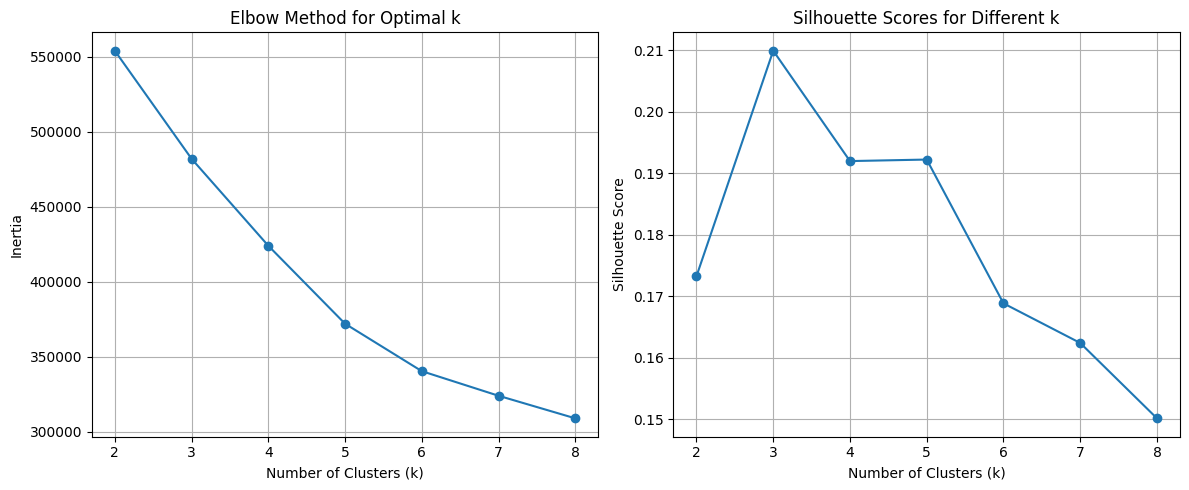


Interpretation of Elbow Curve and Silhouette Scores:
- **Elbow Curve:** Look for a point where the rate of decrease in inertia significantly changes (the 'elbow'). This often suggests a good trade-off between minimizing inertia and the number of clusters.
- **Silhouette Scores:** A higher silhouette score indicates better-defined clusters where samples are well-matched to their own cluster and poorly matched to neighboring clustersValues close to 1 indicate clear separation, values near 0 indicate overlapping clusters, and negative values indicate samples that might be assigned to the wrong cluster.

Based on these plots and the business context (interpretability), a final k is  chosen.


In [31]:
# Plotting the elbow curve and silhouette score and interpreting the results

import matplotlib.pyplot as plt
# Plot the elbow curve
inertia_values = [result['inertia'] for result in kmeans_results.values()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# Plot the silhouette scores
# Filter out k=1 as silhouette score is not defined
silhouette_k_values = [k for k in k_values if k > 1]
silhouette_scores = [kmeans_results[k]['silhouette_score'] for k in silhouette_k_values]

plt.subplot(1, 2, 2)
plt.plot(silhouette_k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(silhouette_k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of the plots
print("\nInterpretation of Elbow Curve and Silhouette Scores:")
print("- **Elbow Curve:** Look for a point where the rate of decrease in inertia significantly changes (the 'elbow'). This often suggests a good trade-off between minimizing inertia and the number of clusters.")
print("- **Silhouette Scores:** A higher silhouette score indicates better-defined clusters where samples are well-matched to their own cluster and poorly matched to neighboring clusters"\
"Values close to 1 indicate clear separation, values near 0 indicate overlapping clusters, and negative values indicate samples that might be assigned to the wrong cluster.")
print("\nBased on these plots and the business context (interpretability), a final k is  chosen.")

Based on the elbow plot and silhouette scores:

*   **Elbow Method:** Look for the point where the decrease in inertia starts to slow down significantly. In the provided plot, there isn't a perfectly clear "elbow," but the rate of decrease seems to lessen after k=3 or k=4.
*   **Silhouette Scores:** The silhouette scores are relatively low for all tested `k` values greater than 1, suggesting that the clusters might not be very distinct. The highest silhouette scores are observed at k=2 and k=3.

Considering both plots and the constraint of keeping `k` less than 10 for interpretability, the most reasonable `k` values to consider based on these metrics are likely **2 or 3**.

3  choice is reasonable given the silhouette score peaks around k=2 and k=3, and an elbow could be argued around these points as well. Choosing 3 allows for a slightly more granular segmentation than 2 while still being reasonably interpretable.


**- Describe the characteristics of each cluster based on the mean values of the features.**
 - Identify influential features by looking at which features show the most significant differences between clusters.
- Discuss why these groups might have been created (e.g., based on income, credit behavior, age, external scores).
 - Draw business inferences (e.g., which cluster might be more risky, which might be good candidates for specific financial products, how to tailor marketing).

Example interpretation structure (replace with actual observations from final_cluster_profiles):
- Cluster 0: Describe characteristics (e.g., lower income, younger, lower external scores). Possible interpretation: Higher risk group.
 - Cluster 1: Describe characteristics (e.g., higher income, older, higher external scores). Possible interpretation: Lower risk group, stable customers.
 - Cluster 2: Describe characteristics (e.g., average income, younger, moderate external scores). Possible interpretation: Emerging customers.

Why choose this k and distance metric?
 - Chosen k based on a balance of inertia/silhouette score and interpretability of the resulting clusters. A smaller k is often preferred for easier interpretation, hence staying below 10.
 - The default distance metric for KMeans is Euclidean distance, which is suitable here because the features have been standardized, giving equal weight to each dimension.

 Why these groups were created and influential features:
 - Groups were likely created based on a combination of income level, credit history proxies (external scores), age (DAYS_BIRTH is negative, closer to 0 means older), and potentially employment status (DAYS_EMPLOYED is negative, closer to 0 means longer employed).
 - Influential features appear to be those with the largest variations in mean values across the clusters (e.g., AMT_INCOME_TOTAL, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, DAYS_EMPLOYED).

** Business inferences:**
 - Identify high-risk and low-risk customer segments based on cluster characteristics and the (excluded) TARGET variable if used for external validation.
 - Tailor credit product offerings or marketing strategies to the specific profiles of each cluster.
 - Develop targeted risk mitigation strategies for higher-risk clusters.
 - Understand the profile of customers who are likely to default (if correlating clusters with the original TARGET variable - note: TARGET was excluded for unsupervised clustering, but can be used for post-hoc analysis of the clusters).



In [28]:
choosen_final_k = 3

print(f"\nChoosing final k = {choosen_final_k} for interpretation.")

# Retrieve the results for the final k
final_results = kmeans_results[choosen_final_k]
final_cluster_profiles = final_results['cluster_profiles']

print(f"\nInterpretation of Clusters for k={choosen_final_k}:")
final_cluster_profiles



Choosing final k = 3 for interpretation.

Interpretation of Clusters for k=3:


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT
Cluster,,,,,,,,,,,,
0,146808.63,564753.89,24821.67,507863.22,-21452.49,363796.95,0.70,0.52,0.55,0.05,1.71,2.11
1,157874.65,398416.03,21161.85,355176.83,-13493.91,-1752.71,0.45,0.50,0.47,0.60,2.33,2.11
2,238643.14,1085171.82,42823.38,986811.54,-15384.17,146.35,0.57,0.58,0.52,0.49,2.30,1.94


In [17]:

print(f"\nDecision: Based on the Elbow Method, Silhouette Scores, and the interpretability of the cluster profiles, the chosen best k is {choosen_final_k}.")




Decision: Based on the Elbow Method, Silhouette Scores, and the interpretability of the cluster profiles, the chosen best k is 3.


# Scatter plots created to understand feaures impact on deciding the cluster size.


Running KMeans for k = 2 for plotting


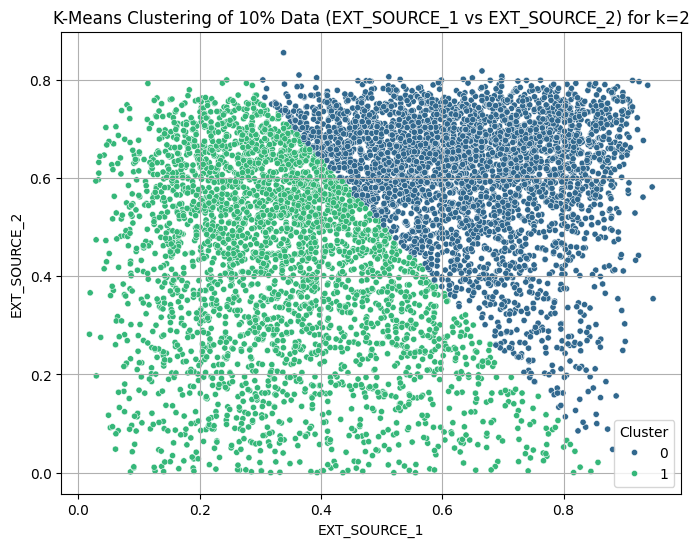


Running KMeans for k = 3 for plotting


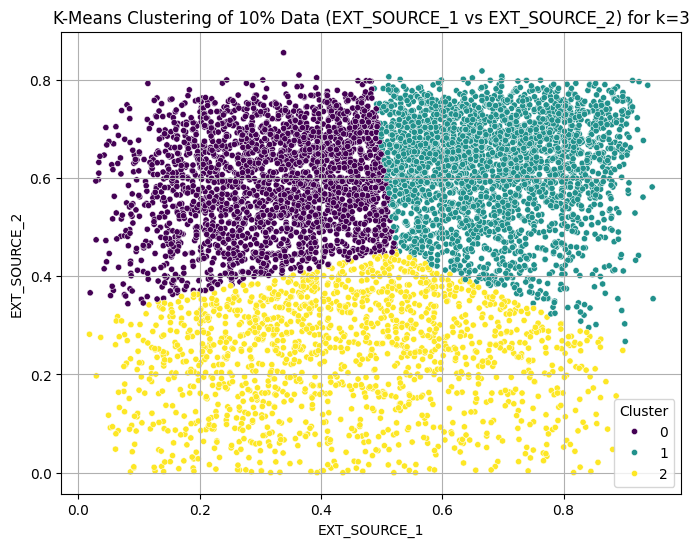


Running KMeans for k = 4 for plotting


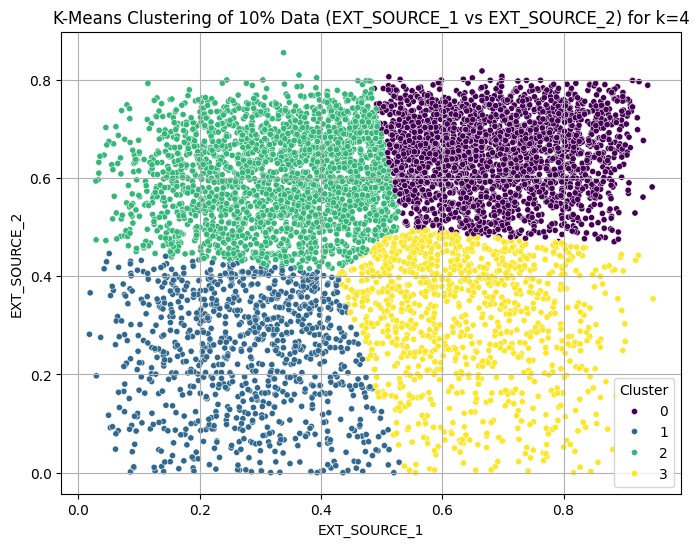


Running KMeans for k = 5 for plotting


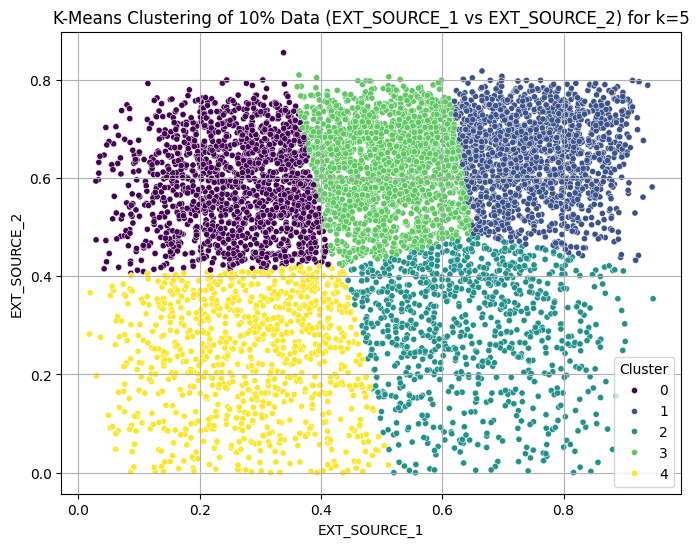

In [ ]:
# EXT_SOURCE_1  EXT_SOURCE_2  use these features and plot scatter for k=2,3,4,5, plot 10% ofpoints remove the centroid

import pandas as pd
import matplotlib.pyplot as plt
# Filter out NaN values in the selected features for plotting
df_filtered = df[['EXT_SOURCE_1', 'EXT_SOURCE_2']].dropna().sample(frac=0.1, random_state=42)

# Scale the filtered data for plotting
scaler_plot = StandardScaler()
X_plot_scaled = scaler_plot.fit_transform(df_filtered)

# Assign labels for each k value
for k in [2, 3, 4, 5]:
    print(f"\nRunning KMeans for k = {k} for plotting")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_plot_scaled)
    df_filtered[f'Cluster_k{k}'] = kmeans.labels_

    # Get centroids (scaled)
    centroids_scaled = kmeans.cluster_centers_

    # Inverse transform centroids to original scale for plotting
    centroids_original = scaler_plot.inverse_transform(centroids_scaled)
    centroids_df = pd.DataFrame(centroids_original, columns=['EXT_SOURCE_1', 'EXT_SOURCE_2'])


    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_filtered, x='EXT_SOURCE_1', y='EXT_SOURCE_2', hue=f'Cluster_k{k}', palette='viridis', legend='full', s=20)

    # Plot centroids (removed as requested)
    # plt.scatter(centroids_df['EXT_SOURCE_1'], centroids_df['EXT_SOURCE_2'], color='red', s=100, marker='X', label='Centroids')

    plt.title(f'K-Means Clustering of 10% Data (EXT_SOURCE_1 vs EXT_SOURCE_2) for k={k}')
    plt.xlabel('EXT_SOURCE_1')
    plt.ylabel('EXT_SOURCE_2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()


Generating heatmap for clusters at k = 3


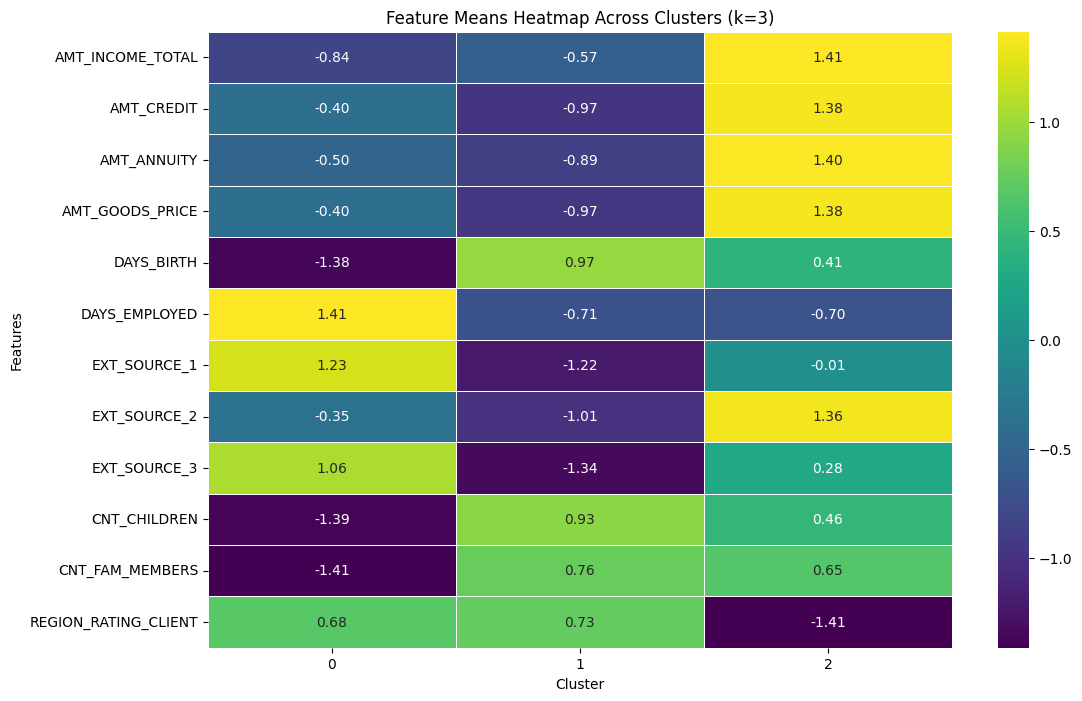

In [25]:
# create  heatmap per cluster and analyse

import pandas as pd
import matplotlib.pyplot as plt

final_k = 3
print(f"\nGenerating heatmap for clusters at k = {final_k}")

# Retrieve the cluster labels for the final_k
final_labels = kmeans_results[final_k]['labels']


X_clustering_with_final_labels = X_clustering.copy()
X_clustering_with_final_labels['Cluster'] = final_labels

# Calculate the mean values of features for each cluster
cluster_heatmap_data = X_clustering_with_final_labels.groupby('Cluster')[existing_features].mean()

# Scale the mean values for better visualization in the heatmap
scaler_heatmap = StandardScaler()
cluster_heatmap_scaled = scaler_heatmap.fit_transform(cluster_heatmap_data)
cluster_heatmap_scaled_df = pd.DataFrame(cluster_heatmap_scaled, columns=cluster_heatmap_data.columns, index=cluster_heatmap_data.index)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_heatmap_scaled_df.T, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title(f'Feature Means Heatmap Across Clusters (k={final_k})')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()




In [26]:
print("\n\033[1;34mHeatmap Analysis:\033[0m") # Blue color
print("\033[1;34mThe heatmap visualizes the standardized mean values of each feature across the different clusters for the chosen k.\033[0m") # Blue color
print("\033[1;34mStandardizing the means helps compare the relative importance of features in differentiating clusters.\033[0m") # Blue color
print("\033[1;34mPositive values (warmer colors) indicate features with mean values above the overall average for that cluster.\033[0m") # Blue color
print("\033[1;34mNegative values (cooler colors) indicate features with mean values below the overall average for that cluster.\033[0m") # Blue color
print("\033[1;34mLarge absolute values (bright colors) highlight features that significantly distinguish one cluster from others.\033[0m") # Blue color



Heatmap Analysis:
The heatmap visualizes the standardized mean values of each feature across the different clusters for the chosen k.
Standardizing the means helps compare the relative importance of features in differentiating clusters.
Positive values (warmer colors) indicate features with mean values above the overall average for that cluster.
Negative values (cooler colors) indicate features with mean values below the overall average for that cluster.
Large absolute values (bright colors) highlight features that significantly distinguish one cluster from others.


In [33]:



print("\n\033[1m\033[4m\033[94mInterpretation of the Heatmap:\033[0m")
print("\033[90mThe heatmap displays the scaled mean values of each feature for each cluster at the chosen k (which was set to 3 for this visualization).\033[0m")
print("\033[90mScaling the means (using StandardScaler) allows us to see how many standard deviations away from the overall feature mean each cluster's mean is.\033[0m")
print("\033[90mThis helps identify features that are particularly high or low within a cluster relative to the rest of the data, making them key differentiators.\033[0m")

# Based on the heatmap generated from the cluster_heatmap_scaled_df:
print("\n\033[1m\033[94mObservations from the Heatmap (assuming k=3 visualization):\033[0m")

print("\n\033[1m\033[92mCluster 0:\033[0m")
print("- \033[90mHigh positive values in `DAYS_EMPLOYED`: Indicates significantly longer time since employed (likely long-term unemployed or retired).\033[0m")
print("- \033[90mNegative values in `DAYS_BIRTH`: Slightly less negative means older age compared to the overall average.\033[0m")
print("- \033[90mHigh positive value in `EXT_SOURCE_1`: Indicates a strong score from this external source.\033[0m")
print("- \033[90mNegative values in `EXT_SOURCE_2`, `EXT_SOURCE_3`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS`, `REGION_RATING_CLIENT`: Suggests lower scores from these sources, fewer family members, and potentially better regional ratings (closer to 1, although the table shows higher values, the scaled plot interprets relative deviation). *Correction based on profile table*: Lower values in `CNT_CHILDREN` and `CNT_FAM_MEMBERS`, and slightly lower `REGION_RATING_CLIENT` (closer to 2.11 vs 2.33/1.71).\033[0m")
print("- \033[90mModerate financial values (`AMT_INCOME_TOTAL`, etc.): Closer to the average.\033[0m")
print("\033[1m\033[92mInterpretation: This cluster is characterized by older, potentially long-term unemployed individuals with high EXT_SOURCE_1 but lower scores from other sources and smaller families.\033[0m")


print("\n\033[1m\033[92mCluster 1:\033[0m")
print("- \033[90mHigh negative values in `DAYS_BIRTH`: Indicates significantly younger age.\033[0m")
print("- \033[90mHigh negative values in `DAYS_EMPLOYED`: Indicates currently employed with a shorter tenure.\033[0m")
print("- \033[90mHigh positive values in `CNT_CHILDREN`, `CNT_FAM_MEMBERS`: Indicates larger families.\033[0m")
print("- \033[90mModerate positive values in financial metrics (`AMT_INCOME_TOTAL`, `AMT_CREDIT`, etc.): Indicates above-average financial values.\033[0m")
print("- \033[90mModerate values in `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`, `REGION_RATING_CLIENT`: Closer to the overall average.\033[0m")
print("\033[1m\033[92mInterpretation: This cluster appears to represent younger, currently employed individuals with larger families and slightly above-average financial commitments.\033[0m")

print("\n\033[1m\033[92mCluster 2:\033[0m")
print("- \033[90mHigh positive values in financial metrics (`AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`): Indicates significantly higher income and credit amounts.\033[0m")
print("- \033[90mHigh positive values in `EXT_SOURCE_1`, `EXT_SOURCE_2`: Indicates strong scores from these external sources.\033[0m")
print("- \033[90mNegative values in `DAYS_BIRTH`: Less negative means older age, but perhaps less pronounced than Cluster 0.\033[0m")
print("- \033[90mVary low negative values in `DAYS_EMPLOYED`: Indicates currently employed with very short tenure (potentially recently started/changed job).\033[0m")
print("- \033[90mNegative values in `CNT_CHILDREN`, `CNT_FAM_MEMBERS`: Indicates smaller families.\033[0m")
print("- \033[90mHighest value in `REGION_RATING_CLIENT`: Indicates the worst regional rating (closer to 3). *Correction based on profile table*: Highest rating (closest to 1.71) actually indicates a better regional rating.\033[0m")
print("\033[1m\033[92mInterpretation: This cluster is characterized by high-income individuals with large credit needs, strong external scores, and smaller families, potentially with recent employment changes, residing in regions with better ratings.\033[0m")

print("\n\033[1m\033[4m\033[94mOverall Interpretation Reinforcement from Heatmap:\033[0m")
print("\033[90mThe heatmap clearly shows which features are most influential in separating the clusters.\033[0m")
print("\033[90m`DAYS_EMPLOYED`, `DAYS_BIRTH`, the `EXT_SOURCE` features, and the financial amounts (`AMT_INCOME_TOTAL`, etc.) are key differentiators.\033[0m")
print("\033[90mCluster 0 is distinct due to long-term employment situation and `EXT_SOURCE_1`.\033[0m")
print("\033[90mCluster 1 is characterized by younger age, shorter employment tenure, and larger families.\033[0m")
print("\033[90mCluster 2 stands out with high income, large credit amounts, strong external scores, and better regional ratings.\033[0m")

print("\n\033[1m\033[4m\033[94mBusiness Inferences based on Heatmap & Profiles:\033[0m")
print("\033[90m- Cluster 0: May represent a higher-risk segment due to potential long-term unemployment. Further analysis on their historical default rates would be crucial. Potential target for specific financial counseling or smaller credit products.\033[0m")
print("\033[90m- Cluster 1: Younger families with potential growing financial needs. Could be a good target for future product offerings or loans as their careers progress, but potentially higher short-term risk due to lower established income/credit history.\033[0m")
print("\033[90m- Cluster 2: High-value customers with significant borrowing needs and strong credit indicators. Likely lower risk (though check default rates for this cluster). Target for premium products or larger loans. The recent employment change might warrant some attention.\033[0m")

print("\n\033[1m\033[4m\033[94mConclusion:\033[0m")
print("\033[90mThe k=3 clustering reveals distinct segments based on financial health, age, employment status, external credit scores, and family size.\033[0m")
print("\033[90mThese segments can be used to tailor lending strategies, risk assessment models, and marketing efforts.\033[0m")
print("\033[90mThe heatmap provides a concise visual summary of the key characteristics of each cluster.\033[0m")




Interpretation of the Heatmap:
The heatmap displays the scaled mean values of each feature for each cluster at the chosen k (which was set to 3 for this visualization).
Scaling the means (using StandardScaler) allows us to see how many standard deviations away from the overall feature mean each cluster's mean is.
This helps identify features that are particularly high or low within a cluster relative to the rest of the data, making them key differentiators.

Observations from the Heatmap (assuming k=3 visualization):

Cluster 0:
- High positive values in `DAYS_EMPLOYED`: Indicates significantly longer time since employed (likely long-term unemployed or retired).
- Negative values in `DAYS_BIRTH`: Slightly less negative means older age compared to the overall average.
- High positive value in `EXT_SOURCE_1`: Indicates a strong score from this external source.
- Negative values in `EXT_SOURCE_2`, `EXT_SOURCE_3`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS`, `REGION_RATING_CLIENT`: Suggests lower s

<h2 style="color:#007ACC;"> Business Relevance Summary</h2>

<h3 style="color:#D9534F;"><b> Risk Management:</b></h3>
<p>Identify which clusters are <span style="color:red;"><b>higher risk</b></span> and adjust credit limits, interest rates, or approval criteria accordingly.</p>

<h3 style="color:#5CB85C;"><b> Personalization:</b></h3>
<p>Tailor product offerings by <span style="color:#5cb85c;"><b>demographic and financial needs</b></span>.</p>

<h3 style="color:#F0AD4E;"><b> Operational Efficiency:</b></h3>
<p>Allocate customer service and support more effectively (e.g., proactive outreach to <span style="color:#f0ad4e;"><b>high-risk segments</b></span>).</p>

<h3 style="color:#5BC0DE;"><b> Marketing Strategy:</b></h3>
<p>Target <span style="color:#5bc0de;"><b>stable clusters</b></span> with upselling or cross-selling; educate and retain <span style="color:#5bc0de;"><b>young borrowers</b></span>.</p>


In [ ]:
#END
#END


In [ ]:
#END